# Time Series Forecasting: Energy Consumption in the US
#### Based on tutorial by Rob Mulla - with additions from me to tune hyperparameters
#### Link : https://www.youtube.com/watch?v=vV12dGe_Fho

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

plt.style.use('fivethirtyeight')
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()

##### Types of Time Series Data
There are different types of time series data.
- Completely random - There would be not point in modeling
- Exponential Growth - Like the stock market
- Increasing linear trends - steady growth
- Seasonal patterns - weather
- Season patterns with growth


In [2]:
# Read in dataframe
df = pd.read_csv('Energy_Consumption/PJME_hourly.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  145366 non-null  object 
 1   PJME_MW   145366 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB


,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [3]:
# set index
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

In [4]:
df.index

DatetimeIndex(['2002-12-31 01:00:00', '2002-12-31 02:00:00',
               '2002-12-31 03:00:00', '2002-12-31 04:00:00',
               '2002-12-31 05:00:00', '2002-12-31 06:00:00',
               '2002-12-31 07:00:00', '2002-12-31 08:00:00',
               '2002-12-31 09:00:00', '2002-12-31 10:00:00',
               ...
               '2018-01-01 15:00:00', '2018-01-01 16:00:00',
               '2018-01-01 17:00:00', '2018-01-01 18:00:00',
               '2018-01-01 19:00:00', '2018-01-01 20:00:00',
               '2018-01-01 21:00:00', '2018-01-01 22:00:00',
               '2018-01-01 23:00:00', '2018-01-02 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=145366, freq=None)

<Axes: title={'center': 'PJME Energy Use in MW'}, xlabel='Datetime'>

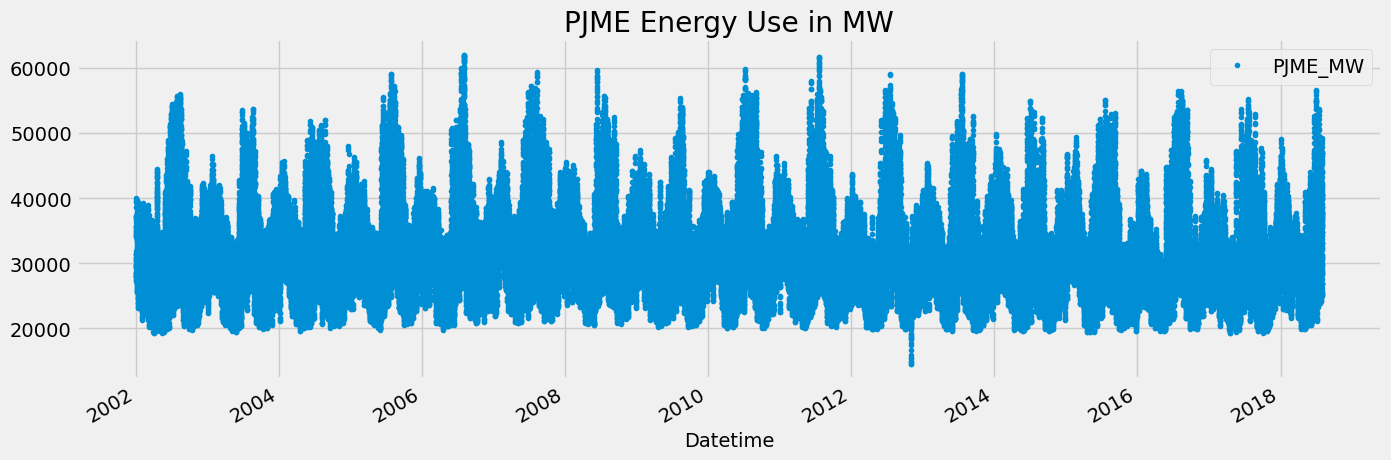

In [5]:
df.plot(style='.', figsize=(15,5), color=color_pal[0],title='PJME Energy Use in MW')

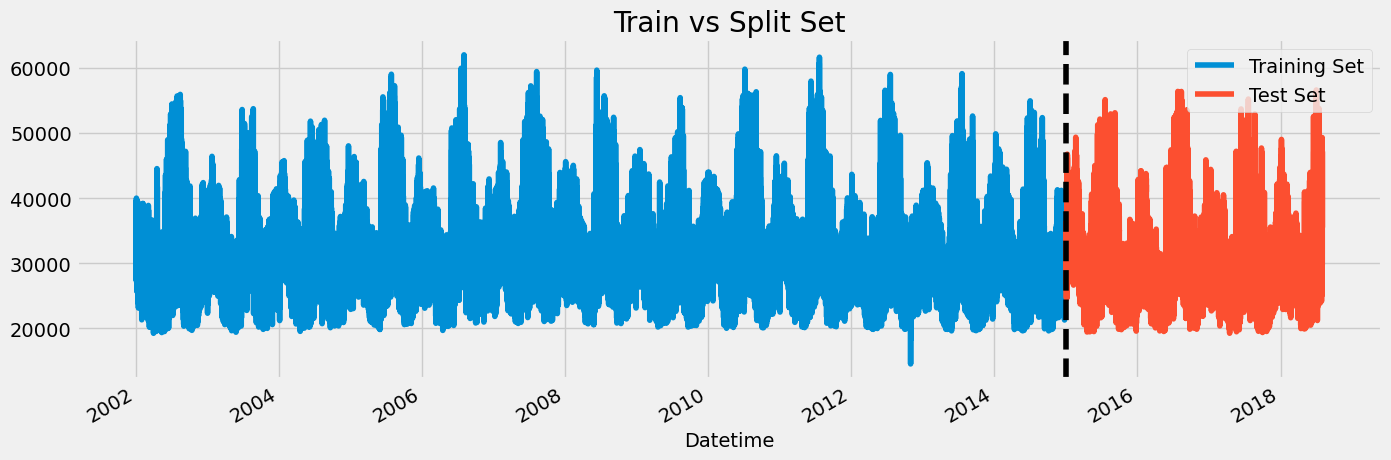

In [6]:
# show plot
train = df.loc[df.index < '2015-01-01']
test = df.loc[df.index >= '2015-01-01']


fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label = 'Training Set', title = 'Train vs Split Set')
test.plot(ax=ax, label='Test Set')
ax.axvline(pd.to_datetime('01-01-2015'), color='black', ls= '--')
ax.legend(['Training Set' ,'Test Set'])
plt.show()

<Axes: xlabel='Datetime'>

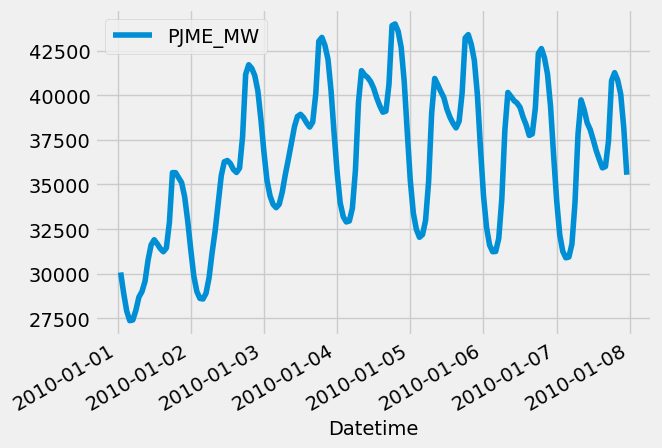

In [7]:
# Plotting a shorter time frame to see what a week would look like
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')].plot()

In [8]:
def create_features(df):
    """
    Create time series features based on time series index
    """
    df_copy = df.copy()
    df_copy['hour'] = df_copy.index.hour
    df_copy['dayofweek'] = df_copy.index.dayofweek
    df_copy['quarter'] = df_copy.index.quarter
    df_copy['month'] = df_copy.index.month
    df_copy['year'] = df_copy.index.year
    df_copy['dayofyear'] = df_copy.index.dayofyear
    return df_copy

Text(0.5, 1.0, 'MW by Month')

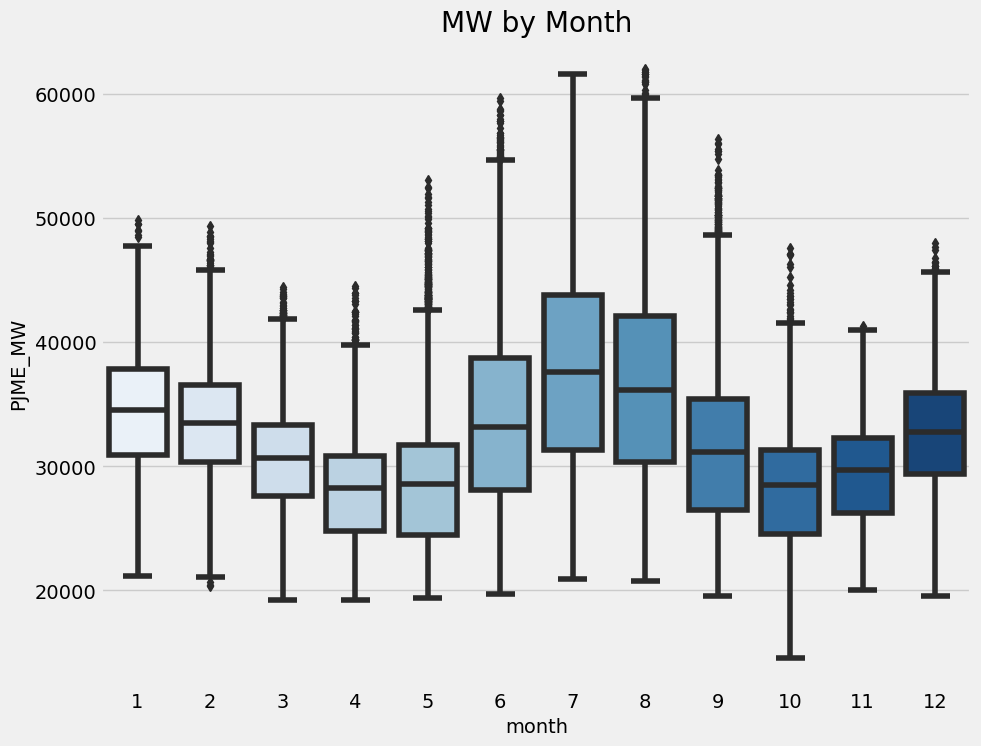

In [9]:
# visualize feature/target relationship
df = create_features(df)
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette = 'Blues')
ax.set_title('MW by Month')

Key model hyperparameters:
- tree structure (weak trees do not go very deep, which can be preferred)
- regularization (not paying attention to certain features)
- weights
- number of trees/estimators
- learning rate
- hyperopt optimization
- sklearn - grid search - THIS IS THE ONE I WILL ATTEMPT



In [10]:
# Create Model

train= create_features(train)
test = create_features(test)

ESTIMATORS = 1000
STOPPING_ROUND = 50

FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

# Define the parameter grid for grid search

param_grid = {
    'n_estimators': [60, 70],
    'learning_rate': [0.22, 0.23],
    'max_depth': [5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

# Create an XGBoost regressor
reg = xgb.XGBRegressor(n_estimators=ESTIMATORS, early_stopping_rounds=STOPPING_ROUND)
reg.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
# Perform grid search
grid_search = GridSearchCV(reg, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_

# Train the model with the best hyperparameters
best_reg = xgb.XGBRegressor(**best_params, early_stopping_rounds=STOPPING_ROUND)
best_reg.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

predictions_grid = best_reg.predict(X_test)
predictions_reg = reg.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions_grid)
mse2 = mean_squared_error(y_test, predictions_reg)
print(f"Best Mean Squared Error with Grid Search: {mse}")
print(f"Best Mean Squared Error without Grid Search: {mse2}")
print("Best Hyperparameters:", best_params)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best Mean Squared Error with Grid Search: 14067428.120008275
Best Mean Squared Error without Grid Search: 14130957.07824267
Best Hyperparameters: {'colsample_bytree': 0.9, 'learning_rate': 0.22, 'max_depth': 5, 'n_estimators': 60, 'subsample': 0.8}


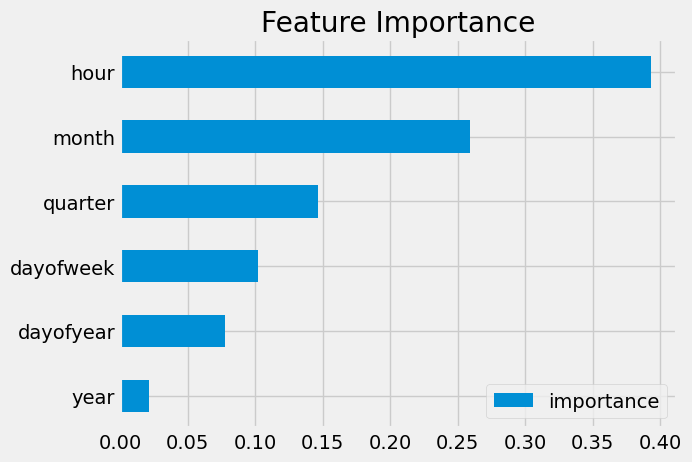

In [11]:
fi = pd.DataFrame(data=best_reg.feature_importances_,
             index=best_reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

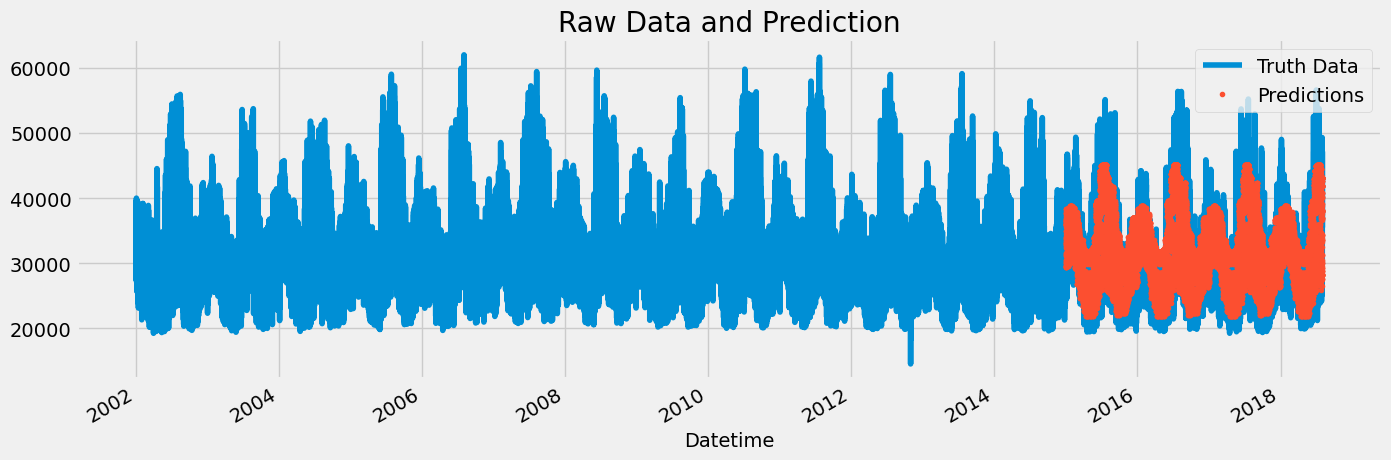

In [12]:
# Forecast on test set
test['prediction'] = best_reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

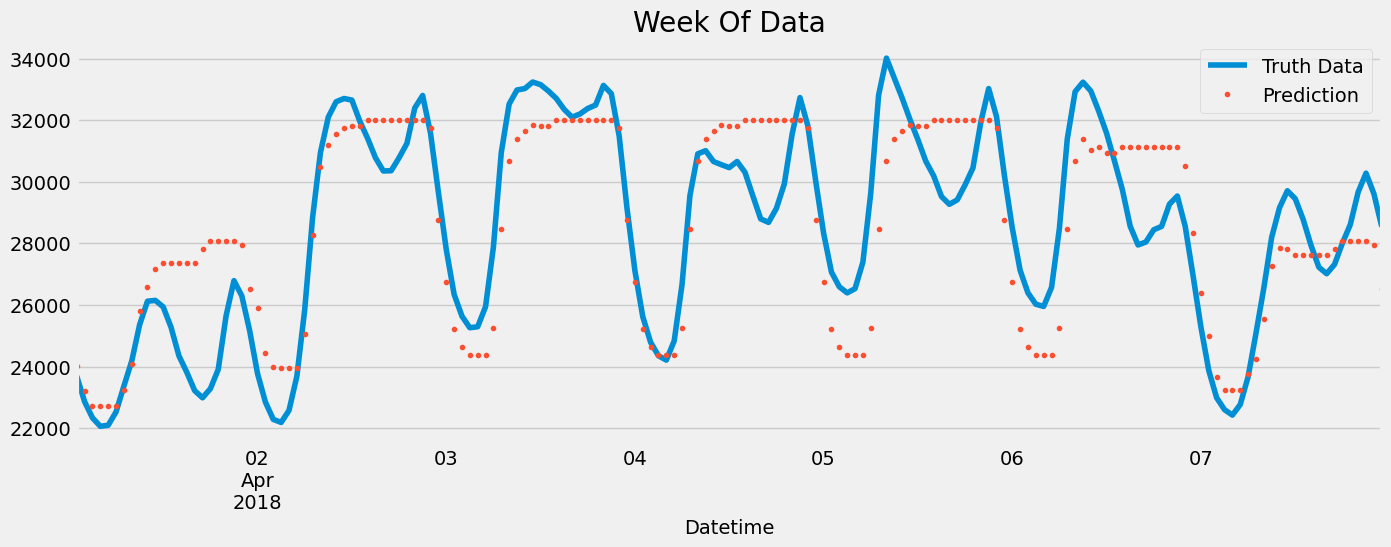

In [13]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()